In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_context('paper')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 14

In [3]:
TelN_data = pd.read_csv("/data1/normantm/angel/TelN_no_sv_per_base_identity.txt", sep="\t", index_col=0)
plasmid_data = pd.read_csv("/data1/normantm/angel/plasmid_no_sv_per_base_identity.txt", sep="\t", index_col=0)

In [4]:
barcode_regions = [
    (5099, 5119), 
    (5348, 5368), 
    (5492, 5517)
]

In [5]:
def plot_identity(
    positions, 
    identity, 
    ref_regions, 
    window_size=10, 
    exclude_barcodes=True,
    savefig=False,
    filename="TelN_positional_identity_pacbio.svg"
):
    
    plt.figure(figsize=(10, 1.2))
    ax = plt.gca()
    
    plt.plot(positions, identity, color='black', linewidth=0.5, alpha=0.7, label='Percent Identity')
    
    
    # Highlight barcode regions
    for (start, end) in ref_regions:
        plt.axvspan(start, end, color='red', alpha=0.2, label='barcode / protospacer regions')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    
    plt.xlabel(f"Position")
    plt.ylabel("% Identity")
    plt.ylim(0, 101)
    plt.xlim(0, positions[-1] - 1)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), frameon=False, loc="lower left")  # Remove legend frame

    if savefig:
        plt.savefig(filename, bbox_inches='tight', transparent=True, pad_inches=0.1)

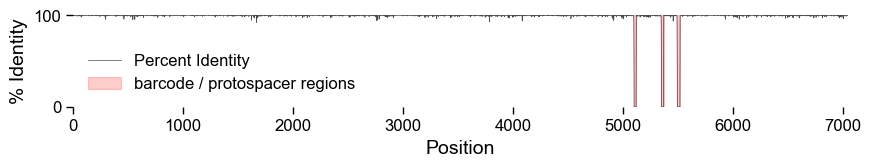

In [6]:
plot_identity(TelN_data.index.values, TelN_data.Percent_Identity.values, barcode_regions)

In [7]:
TelN_mask = (
    TelN_data.index.to_series().between(5094, 5123, inclusive='both') |
    TelN_data.index.to_series().between(5343, 5372, inclusive='both') |
    TelN_data.index.to_series().between(5487, 5521, inclusive='both') |
    (TelN_data.index.to_series() < 1031) |
    (TelN_data.index.to_series() > 5991)
)

In [8]:
plasmid_mask = (
    plasmid_data.index.to_series().between(6165, 6194, inclusive='both') |
    plasmid_data.index.to_series().between(6414, 6443, inclusive='both') |
    plasmid_data.index.to_series().between(6558, 6592, inclusive='both') |
    (plasmid_data.index.to_series() < 2102) |
    (plasmid_data.index.to_series() > 7062)
)

In [9]:
TelN_filtered = TelN_data[~TelN_mask].Percent_Identity.reset_index().reset_index()
TelN_filtered["Cloning method"] = "TelN"
plasmid_filtered = plasmid_data[~plasmid_mask].Percent_Identity.reset_index().reset_index()
plasmid_filtered["Cloning method"] = "Bacterial"

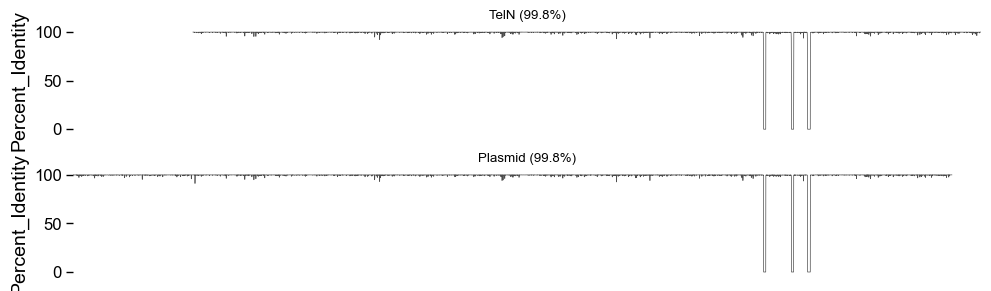

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Transformation (Alignment) ---
# Create a new, aligned x-axis for TelN_data
# The alignment starts at position 1031, so we subtract 1031 from all positions.
# The aligned region 1031:5991 will now span 0:4960.
TelN_data['Aligned_Position'] = TelN_data.index - 1031

# Create a new, aligned x-axis for plasmid_data
# The alignment starts at position 2102, so we subtract 2102 from all positions.
# The aligned region 2102:7062 will now also span 0:4960.
plasmid_data['Aligned_Position'] = plasmid_data.index - 2102

fig, ax = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

sns.lineplot(data=TelN_data, x="Aligned_Position", y="Percent_Identity",
             color='black', linewidth=0.5, alpha=0.7,  ax=ax[0])
ax[0].set_title(f'TelN ({TelN_filtered.Percent_Identity.mean():.1f}%)')
ax[0].set_xlabel('')

sns.lineplot(data=plasmid_data, x="Aligned_Position", y="Percent_Identity",
             color='black', linewidth=0.5, alpha=0.7, ax=ax[1])
ax[1].set_title(f'Plasmid ({plasmid_filtered.Percent_Identity.mean():.1f}%)')
ax[1].set_xlabel('')

for spine in ax[0].spines.values():
    spine.set_visible(False)
for spine in ax[1].spines.values():
    spine.set_visible(False)

ax[1].set_xticks([])
min_aligned = min(TelN_data['Aligned_Position'].min(), plasmid_data['Aligned_Position'].min())
max_aligned = max(TelN_data['Aligned_Position'].max(), plasmid_data['Aligned_Position'].max())
ax[1].set_xlim(left=min_aligned, right=max_aligned)

plt.tight_layout()

# fig.savefig('compare_pacbio_TelN_plasmid.svg', bbox_inches="tight")

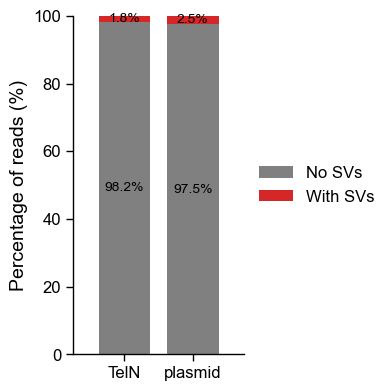


Summary:
Sample 1: 1.82% reads with SVs (18,306/1,004,218)
Sample 2: 2.54% reads with SVs (30,743/1,211,840)


In [11]:
# Sample names
sample_names = ['TelN', 'plasmid']
# Parse results for both samples
sample1_file = '/data1/normantm/angel/TelN_sniffles_results.txt'
sample2_file = '/data1/normantm/angel/plasmid_sniffles_results.txt'

import matplotlib.pyplot as plt
import numpy as np
import re

def parse_sniffles_results(filepath):
    """Parse Sniffles analysis results file"""
    with open(filepath, 'r') as f:
        content = f.read()
    
    # Extract total reads
    total_reads_match = re.search(r'Total reads:\s+(\d+)', content)
    total_reads = int(total_reads_match.group(1)) if total_reads_match else 0
    
    # Extract unique reads supporting SVs
    sv_reads_match = re.search(r'Total SV read instances:\s+(\d+)', content)
    sv_reads = int(sv_reads_match.group(1)) if sv_reads_match else 0
    
    return {
        'total_reads': total_reads,
        'sv_reads': sv_reads,
    }

data1 = parse_sniffles_results(sample1_file)
data2 = parse_sniffles_results(sample2_file)

# Calculate percentages
sample1_total = data1['total_reads']
sample2_total = data2['total_reads']

sample1_no_sv_pct = ((sample1_total - data1['sv_reads']) / sample1_total) * 100
sample1_sv_pct = (data1['sv_reads'] / sample1_total) * 100

sample2_no_sv_pct = ((sample2_total - data2['sv_reads']) / sample2_total) * 100
sample2_sv_pct = (data2['sv_reads'] / sample2_total) * 100

fig, ax = plt.subplots(figsize=(4, 4))

x = [0.4, 0.8]
width = 0.3

no_sv = [sample1_no_sv_pct, sample2_no_sv_pct]
with_sv = [sample1_sv_pct, sample2_sv_pct]

color_no_sv = '#808080'
color_sv = '#d62728'

ax.bar(x, no_sv, width, label='No SVs', color=color_no_sv)
ax.bar(x, with_sv, width, bottom=no_sv, label='With SVs', color=color_sv)

ax.set_ylabel('Percentage of reads (%)')
ax.set_xticks(x)
ax.set_xticklabels(sample_names)
ax.set_xlim(0.1, 1.1)  # Tight x-axis limits
ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0, 100)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params()

for i, (pos, no, sv) in enumerate(zip(x, no_sv, with_sv)):
    if no > 5:
        ax.text(pos, no/2, f'{no:.1f}%', ha='center', va='center', 
                fontsize=10, color='black', weight='bold')
    if sv > 1:
        ax.text(pos, no + sv/2, f'{sv:.1f}%', ha='center', va='center', 
                fontsize=10, color='black', weight='bold')

plt.tight_layout()
# plt.savefig('sv_comparison.svg', bbox_inches='tight')
plt.show()

print("\nSummary:")
print(f"Sample 1: {sample1_sv_pct:.2f}% reads with SVs ({data1['sv_reads']:,}/{sample1_total:,})")
print(f"Sample 2: {sample2_sv_pct:.2f}% reads with SVs ({data2['sv_reads']:,}/{sample2_total:,})")